In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Copy gizmo package file from Google Drive to Colab Instance
!cp -r /content/drive/MyDrive/AC297r/gizmo/ ./gizmo

## Locally install `gizmo`
%cd gizmo
!pip install -e .

# Clone teamBlueConduit and install necessary packages and 
!git clone https://github.com/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
!pip install .
!pip install -r requirements.txt > /dev/null

## MAKE SURE TO RESTART KERNEL!

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd



from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import log_loss
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components#n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

import io
import pickle
import zipfile

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *
from blue_conduit_spatial.modeling.diffusion import ServiceLineDiffusion

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

In [ ]:
!ls '# FILEPATH TO GOOGLE DRIVE'

Predictions  Processed	Raw  Tuning


In [ ]:

data_dir = '# GOOGLE DRIVE DATA PATH'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, pid, train_idx, test_idx, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir, 'baseline')

In [ ]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=22)
hexagons.partition_gdf

2021-11-12 18:51.26 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 17392.01it/s]

2021-11-12 18:51.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-12 18:51.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-12 18:51.31 [debug    ] Total parcels after join: 26857
2021-11-12 18:51.31 [info     ] Building the connected graph on the partitions.
2021-11-12 18:51.32 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory


In [ ]:
hexagons.partition_gdf.iloc[1].geometry.area

4380306.001931773

In [ ]:
# load distance data
# this part is slow
dis_path = f'{load_dir}/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)

graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0

print('graph', graph.shape)

graph (26857, 26857)


In [ ]:
# Load in raw distances
haversine_path = f'{load_dir}/haversine_dists.npz'
have_distances = np.load(haversine_path, allow_pickle=True)

have_graph = have_distances['haversine_distances']
#have_graph[have_graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0

print('graph', have_graph.shape)

graph (26857, 26857)


## Compare Over Splits

In [ ]:
resolutions = [22, 47, 99]
train_sizes = [0.1]
n_iter = 1
lam_list = np.linspace(0.5, 0.9, 5)
k_list = [10, 50, 100]
graph_dict = {'road_dist': graph, 'have_dist': have_graph}
dist_func_dict = {'sqrt': ServiceLineDiffusion.sqrt_distances, 'linear': ServiceLineDiffusion.diffusion_distance_weights}
plot_dir = '/content/drive/MyDrive/AC297r/Plots/'
!ls '/content/drive/MyDrive/AC297r/Plots'

diffusion


In [ ]:
pd.options.mode.chained_assignment = None 
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [ ]:
grid_results_logloss = {}
grid_results_auhrc = {}
# Test out ROAD DISTANCES and HAVERSINE DISTANCES
for n, g in graph_dict.items():
  grid_results_logloss[n] = {}
  grid_results_auhrc[n] = {}

  # ONLY HAVE 1 TRAIN SIZE TO TEST
  for i, train_size in enumerate(train_sizes):

    # TEST PERFORMANCE ACROSS THREE SEPARATE RESOLUTIONS
    for j, hex_size in enumerate(resolutions):
      grid_results_logloss[n][hex_size] = {}
      grid_results_auhrc[n][hex_size] = {}
      hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)

      # TEST OUT LINEAR & SQRT DISTANCE FUNCTIONS
      for distfunc_name, distfunc in dist_func_dict.items():
        grid_results_logloss[n][hex_size][distfunc_name] = {}
        grid_results_auhrc[n][hex_size][distfunc_name] = {}

        # TEST OUT VARIOUS k (# NEIGHBOR)
        for k in k_list:
          grid_results_logloss[n][hex_size][distfunc_name][k] = {}
          grid_results_auhrc[n][hex_size][distfunc_name][k] = {}

          # TEST OUT VARIOUS SELF-WEIGHTS => LOWER = MORE SMOOTHING
          for l, lam in enumerate(lam_list):
            print(f"Graph: {n}; Distance Function: {distfunc_name}; weight on self = {round(lam, 2)}; k={k}")

            # AGGREGATE ACROSS 3 SPLITS AND AVERAGE FOR CV
            split_list = []
            split_list_auhrc = []
            init_loglosses = []
            init_auhrcs = []

            for split in range(3):
              print(f"Working on split {split}...")
              (train_index, test_index, 
                Xtrain, Xtest, Ytrain, Ytest, 
                train_pred, test_pred) = tuple(select_data(Xdata, 
                                                    Ydata, 
                                                    pid, 
                                                    train_idx, 
                                                    test_idx, 
                                                    train_pred_all, 
                                                    test_pred_all,
                                                    partitions_builder, 
                                                    train_size=train_size,
                                                    n_hexagons=hex_size,
                                                    split=split, 
                                                    generate_hexagons=False).values())
              init_loglosses.append(log_loss(Ytest, test_pred))
              hrc_init, _, _ = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, test_index, Ytest, test_pred, 0.9)
              init_auhrcs.append(np.trapz(hrc_init))

              slg = ServiceLineDiffusion(g, train_index, test_index, Ytrain, Ytest, train_pred, test_pred, lam=round(lam, 2))
              out = slg.fit(n_iter=n_iter, verbose=False, neighbor_fn=ServiceLineDiffusion.graph_Kneighbors, neighbor_params={'graph':g, 'K': k}, distance_function=distfunc)
              split_list.append(log_loss(Ytest, out[test_index]))
              hrc, _, _ = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, test_index, Ytest, slg.curr_test_pred, 0.9)
              auhrc = np.trapz(hrc)
              split_list_auhrc.append(auhrc)
              #plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred, np.random.beta(0.5, 0.5, size=len(test_pred))], 
              #                    plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {1} it.', 'Random Beta(0.5,0.5)'], 
              #                    mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9, min_digs=1, threshold_increment=0.1, 
              #                    figsize=(8,4), savefig=False, figname=f'{n_iter}iter_{train_size}_{hex_size}_{split}.png', figdir=f'{plot_dir}/diffusion/')

            print(f'Initial logloss: {np.array(init_loglosses).mean()}')
            ll_mean = np.array(split_list).mean()
            print(f"LL: {round(ll_mean, 5)}")
            grid_results_logloss[n][hex_size][distfunc_name][k][lam] = ll_mean

            print(f'Initial AUHRC: {np.array(init_auhrcs).mean()}')
            auhrc_mean = np.array(split_list_auhrc).mean()
            print(f"AUHRC: {round(auhrc_mean, 5)}")
            grid_results_auhrc[n][hex_size][distfunc_name][k][lam] = auhrc_mean

2021-11-10 22:41.53 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 16299.18it/s]

2021-11-10 22:41.56 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 22:41.56 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 22:41.59 [debug    ] Total parcels after join: 26857
2021-11-10 22:41.59 [info     ] Building the connected graph on the partitions.
2021-11-10 22:42.00 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Graph: road_dist; Distance Function: sqrt; weight on self = 0.5; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3316648142545001
LL: 0.26586
Initial AUHRC: 15440.00739640066
AUHRC: 15708.10954
Graph: road_dist; Distance Function: sqrt; weight on self = 0.6; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3316648142545001
LL: 0.25849
Initial AUHRC: 15440.00739640066
AUHRC: 15716.96953
Graph: road_dist; Distance Function: sqrt; weight on self = 0.7; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3316648142545001
LL: 0.25498
Initial AUHRC: 15440.00739640066
AUHRC: 15698.52948
Graph: road_dist; Distance Func

100%|██████████| 1138/1138 [00:00<00:00, 18402.81it/s]

2021-11-10 23:05.08 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 23:05.08 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 23:05.11 [debug    ] Total parcels after join: 26857
2021-11-10 23:05.11 [info     ] Building the connected graph on the partitions.
2021-11-10 23:05.15 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Graph: road_dist; Distance Function: sqrt; weight on self = 0.5; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.29699286143305276
LL: 0.24662
Initial AUHRC: 13605.386059577655
AUHRC: 13802.1903
Graph: road_dist; Distance Function: sqrt; weight on self = 0.6; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.29699286143305276
LL: 0.23842
Initial AUHRC: 13605.386059577655
AUHRC: 13806.8873
Graph: road_dist; Distance Function: sqrt; weight on self = 0.7; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.29699286143305276
LL: 0.23386
Initial AUHRC: 13605.386059577655
AUHRC: 13796.08163
Graph: road_dist; Distance 

100%|██████████| 4828/4828 [00:00<00:00, 18780.30it/s]

2021-11-10 23:33.42 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-10 23:33.42 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-10 23:33.45 [debug    ] Total parcels after join: 26857
2021-11-10 23:33.46 [info     ] Building the connected graph on the partitions.
2021-11-10 23:34.11 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Graph: road_dist; Distance Function: sqrt; weight on self = 0.5; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3332308794591791
LL: 0.26204
Initial AUHRC: 10509.787468902954
AUHRC: 10630.58251
Graph: road_dist; Distance Function: sqrt; weight on self = 0.6; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3332308794591791
LL: 0.25385
Initial AUHRC: 10509.787468902954
AUHRC: 10633.34234
Graph: road_dist; Distance Function: sqrt; weight on self = 0.7; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3332308794591791
LL: 0.24971
Initial AUHRC: 10509.787468902954
AUHRC: 10623.09296
Graph: road_dist; Distance F

100%|██████████| 289/289 [00:00<00:00, 15460.36it/s]

2021-11-11 00:10.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:10.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:10.31 [debug    ] Total parcels after join: 26857
2021-11-11 00:10.31 [info     ] Building the connected graph on the partitions.
2021-11-11 00:10.32 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Graph: have_dist; Distance Function: sqrt; weight on self = 0.5; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3316648142545001
LL: 0.27094
Initial AUHRC: 15440.00739640066
AUHRC: 15686.76747
Graph: have_dist; Distance Function: sqrt; weight on self = 0.6; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3316648142545001
LL: 0.26254
Initial AUHRC: 15440.00739640066
AUHRC: 15694.56064
Graph: have_dist; Distance Function: sqrt; weight on self = 0.7; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3316648142545001
LL: 0.25805
Initial AUHRC: 15440.00739640066
AUHRC: 15690.71578
Graph: have_dist; Distance Func

100%|██████████| 1138/1138 [00:00<00:00, 19215.84it/s]

2021-11-11 00:31.44 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:31.44 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:31.46 [debug    ] Total parcels after join: 26857
2021-11-11 00:31.47 [info     ] Building the connected graph on the partitions.
2021-11-11 00:31.50 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Graph: have_dist; Distance Function: sqrt; weight on self = 0.5; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.29699286143305276
LL: 0.2517
Initial AUHRC: 13605.386059577655
AUHRC: 13778.92823
Graph: have_dist; Distance Function: sqrt; weight on self = 0.6; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.29699286143305276
LL: 0.24244
Initial AUHRC: 13605.386059577655
AUHRC: 13785.74895
Graph: have_dist; Distance Function: sqrt; weight on self = 0.7; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.29699286143305276
LL: 0.23686
Initial AUHRC: 13605.386059577655
AUHRC: 13783.6403
Graph: have_dist; Distance 

100%|██████████| 4828/4828 [00:00<00:00, 19360.28it/s]

2021-11-11 00:58.29 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 00:58.29 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 00:58.32 [debug    ] Total parcels after join: 26857
2021-11-11 00:58.33 [info     ] Building the connected graph on the partitions.
2021-11-11 00:58.58 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Graph: have_dist; Distance Function: sqrt; weight on self = 0.5; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3332308794591791
LL: 0.26569
Initial AUHRC: 10509.787468902954
AUHRC: 10623.5087
Graph: have_dist; Distance Function: sqrt; weight on self = 0.6; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3332308794591791
LL: 0.25683
Initial AUHRC: 10509.787468902954
AUHRC: 10626.794
Graph: have_dist; Distance Function: sqrt; weight on self = 0.7; k=10
Working on split 0...
Working on split 1...
Working on split 2...
Initial logloss: 0.3332308794591791
LL: 0.25202
Initial AUHRC: 10509.787468902954
AUHRC: 10623.66001
Graph: have_dist; Distance Func

In [ ]:
for n in graph_dict.keys():
  for hex_size in resolutions:
    for distfunc_name in dist_func_dict.keys():
      df = pd.DataFrame.from_dict(grid_results_logloss[n][hex_size][distfunc_name])
      print(f"Graph: {n}; Hex Size: {hex_size}; Distance Function: {distfunc_name}")
      display(df.style.applymap(lambda x: 'background-color : yellow' if np.abs(x-df.values.min())<0.0002 else ''))
      if 'sqrt' in distfunc_name:
        d = 'sqrt'
      else:
        d = 'linear'
      df.to_csv(f"{data_dir}/Tuning/logloss_{n}_{hex_size}_{d}.csv")

Graph: road_dist; Hex Size: 22; Distance Function: sqrt


,10,50,100
0.5,0.265858,0.265674,0.270094
0.6,0.258491,0.256819,0.259889
0.7,0.254984,0.251913,0.253734
0.8,0.256727,0.252517,0.253209
0.9,0.267913,0.263238,0.263002


Graph: road_dist; Hex Size: 22; Distance Function: linear


,10,50,100
0.5,0.266203,0.262664,0.265427
0.6,0.258900,0.254793,0.256584
0.7,0.255467,0.250805,0.251681
0.8,0.257273,0.252241,0.252293
0.9,0.268475,0.263651,0.263059


Graph: road_dist; Hex Size: 47; Distance Function: sqrt


,10,50,100
0.5,0.246624,0.248325,0.253210
0.6,0.238417,0.238546,0.242042
0.7,0.233857,0.232519,0.234722
0.8,0.234188,0.231640,0.232662
0.9,0.243193,0.240052,0.240068


Graph: road_dist; Hex Size: 47; Distance Function: linear


,10,50,100
0.5,0.246709,0.244739,0.248008
0.6,0.238570,0.236002,0.238243
0.7,0.234094,0.230944,0.232215
0.8,0.234506,0.230948,0.231337
0.9,0.243552,0.240103,0.239779


Graph: road_dist; Hex Size: 99; Distance Function: sqrt


,10,50,100
0.5,0.262036,0.259722,0.263975
0.6,0.253855,0.249823,0.252486
0.7,0.249710,0.244145,0.245352
0.8,0.251052,0.244343,0.244254
0.9,0.262366,0.255443,0.254330


Graph: road_dist; Hex Size: 99; Distance Function: linear


,10,50,100
0.5,0.262265,0.256205,0.258585
0.6,0.254203,0.247471,0.248685
0.7,0.250178,0.242864,0.243003
0.8,0.251617,0.244028,0.243221
0.9,0.262950,0.255926,0.254440


Graph: have_dist; Hex Size: 22; Distance Function: sqrt


,10,50,100
0.5,0.270941,0.269876,0.273464
0.6,0.262540,0.260365,0.262699
0.7,0.258045,0.254855,0.256048
0.8,0.258835,0.254869,0.255053
0.9,0.269099,0.264943,0.264333


Graph: have_dist; Hex Size: 22; Distance Function: linear


,10,50,100
0.5,0.270942,0.269882,0.273472
0.6,0.262541,0.260368,0.262705
0.7,0.258045,0.254858,0.256052
0.8,0.258835,0.254870,0.255054
0.9,0.269099,0.264943,0.264334


Graph: have_dist; Hex Size: 47; Distance Function: sqrt


,10,50,100
0.5,0.251705,0.251758,0.256311
0.6,0.242437,0.241359,0.244520
0.7,0.236859,0.234760,0.236654
0.8,0.236197,0.233323,0.234088
0.9,0.244211,0.241136,0.240982


Graph: have_dist; Hex Size: 47; Distance Function: linear


,10,50,100
0.5,0.251706,0.251764,0.256320
0.6,0.242438,0.241364,0.244528
0.7,0.236859,0.234763,0.236658
0.8,0.236197,0.233324,0.234090
0.9,0.244211,0.241137,0.240983


Graph: have_dist; Hex Size: 99; Distance Function: sqrt


,10,50,100
0.5,0.265690,0.262760,0.266342
0.6,0.256830,0.252621,0.254503
0.7,0.252017,0.246703,0.247071
0.8,0.252692,0.246627,0.245694
0.9,0.263324,0.257332,0.255460


Graph: have_dist; Hex Size: 99; Distance Function: linear


,10,50,100
0.5,0.265692,0.262768,0.266353
0.6,0.256831,0.252627,0.254511
0.7,0.252018,0.246706,0.247076
0.8,0.252692,0.246629,0.245697
0.9,0.263323,0.257332,0.255460


In [ ]:
for n in graph_dict.keys():
  for hex_size in resolutions:
    for distfunc_name in dist_func_dict.keys():
      df = pd.DataFrame.from_dict(grid_results_auhrc[n][hex_size][distfunc_name])
      print(f"Graph: {n}; Hex Size: {hex_size}; Distance Function: {distfunc_name}")
      display(df.style.applymap(lambda x: 'background-color : yellow' if np.abs(x-df.values.max())<0.5else ''))
      if 'sqrt' in distfunc_name:
        d = 'sqrt'
      else:
        d = 'linear'
      df.to_csv(f"{data_dir}/Tuning/auhrc_{n}_{hex_size}_{d}.csv")

Graph: road_dist; Hex Size: 22; Distance Function: sqrt


,10,50,100
0.5,15708.109539,15722.252199,15703.411996
0.6,15716.969529,15711.693903,15688.782923
0.7,15698.529478,15689.983021,15675.776058
0.8,15667.158139,15666.889468,15642.970875
0.9,15553.362731,15543.444514,15539.147316


Graph: road_dist; Hex Size: 22; Distance Function: linear


,10,50,100
0.5,15700.618995,15719.853214,15711.636274
0.6,15713.001693,15708.626265,15699.959412
0.7,15696.905901,15697.513008,15688.335541
0.8,15666.230597,15670.611959,15666.916528
0.9,15554.119130,15548.031343,15543.670912


Graph: road_dist; Hex Size: 47; Distance Function: sqrt


,10,50,100
0.5,13802.190305,13805.467858,13783.915227
0.6,13806.887301,13804.591420,13788.476442
0.7,13796.081632,13783.972288,13778.734112
0.8,13767.932606,13769.251311,13757.843969
0.9,13690.649118,13679.571905,13674.903348


Graph: road_dist; Hex Size: 47; Distance Function: linear


,10,50,100
0.5,13799.892646,13810.069031,13800.981285
0.6,13805.405093,13812.318666,13799.748498
0.7,13797.485871,13798.161700,13788.415551
0.8,13770.600742,13779.449278,13770.706590
0.9,13693.051841,13683.277557,13679.592713


Graph: road_dist; Hex Size: 99; Distance Function: sqrt


,10,50,100
0.5,10630.582510,10624.310320,10607.239553
0.6,10633.342344,10627.682565,10611.634776
0.7,10623.092964,10614.406620,10602.986705
0.8,10602.845873,10601.459182,10589.412055
0.9,10560.043314,10554.469490,10551.560533


Graph: road_dist; Hex Size: 99; Distance Function: linear


,10,50,100
0.5,10632.309168,10635.964931,10627.736472
0.6,10635.196526,10637.759006,10625.584223
0.7,10623.621568,10619.239755,10613.002601
0.8,10606.613304,10604.541970,10600.136050
0.9,10560.382895,10556.943310,10553.455835


Graph: have_dist; Hex Size: 22; Distance Function: sqrt


,10,50,100
0.5,15686.767471,15684.848644,15670.300309
0.6,15694.560641,15681.581266,15673.864232
0.7,15690.715777,15670.290882,15663.657695
0.8,15664.735395,15653.066439,15644.551246
0.9,15557.855572,15539.120686,15535.082728


Graph: have_dist; Hex Size: 22; Distance Function: linear


,10,50,100
0.5,15686.651498,15684.668447,15669.852941
0.6,15694.533254,15681.577868,15673.827863
0.7,15690.713175,15670.255308,15663.894272
0.8,15664.746426,15652.826925,15644.513305
0.9,15557.861299,15539.115197,15535.084770


Graph: have_dist; Hex Size: 47; Distance Function: sqrt


,10,50,100
0.5,13778.928226,13787.982052,13771.392382
0.6,13785.748955,13786.139343,13775.723684
0.7,13783.640302,13776.702094,13767.243650
0.8,13759.847215,13756.959655,13748.858197
0.9,13685.621220,13676.888858,13674.926955


Graph: have_dist; Hex Size: 47; Distance Function: linear


,10,50,100
0.5,13778.851368,13787.916003,13771.251310
0.6,13785.439036,13786.147763,13775.670989
0.7,13783.585165,13776.642110,13767.240481
0.8,13759.617602,13756.859873,13748.822345
0.9,13685.616649,13676.883636,13674.927760


Graph: have_dist; Hex Size: 99; Distance Function: sqrt


,10,50,100
0.5,10623.508699,10617.248590,10600.896641
0.6,10626.794001,10624.934008,10606.099026
0.7,10623.660009,10610.697615,10598.072114
0.8,10604.631978,10594.272770,10590.600342
0.9,10554.148257,10556.899861,10551.387625


Graph: have_dist; Hex Size: 99; Distance Function: linear


,10,50,100
0.5,10623.490071,10617.255029,10600.857373
0.6,10626.805542,10624.950070,10606.022603
0.7,10623.682554,10610.597010,10598.107969
0.8,10604.633145,10594.255980,10590.637483
0.9,10554.148085,10556.913281,10551.099036


2021-11-11 02:21.13 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 20080.68it/s]

2021-11-11 02:21.16 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-11 02:21.16 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-11 02:21.19 [debug    ] Total parcels after join: 26857
2021-11-11 02:21.19 [info     ] Building the connected graph on the partitions.
2021-11-11 02:21.23 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...


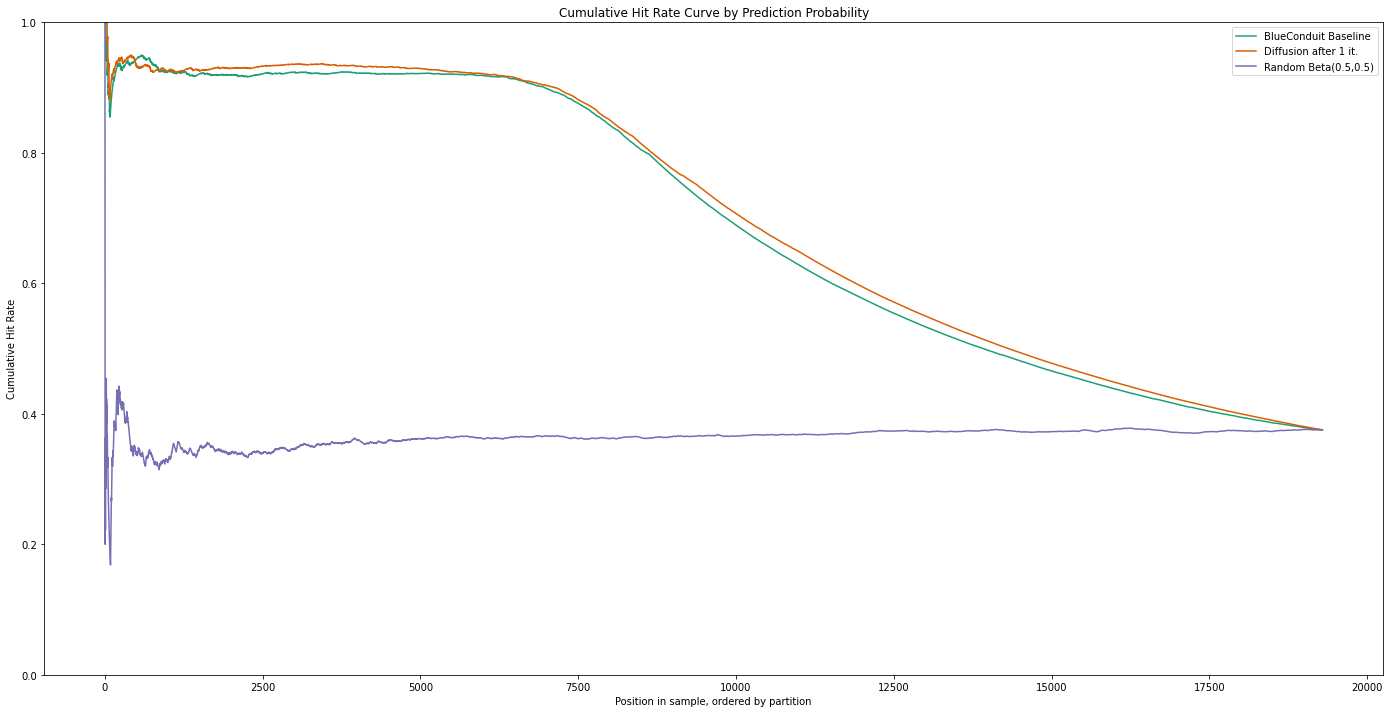

Working on split 1...


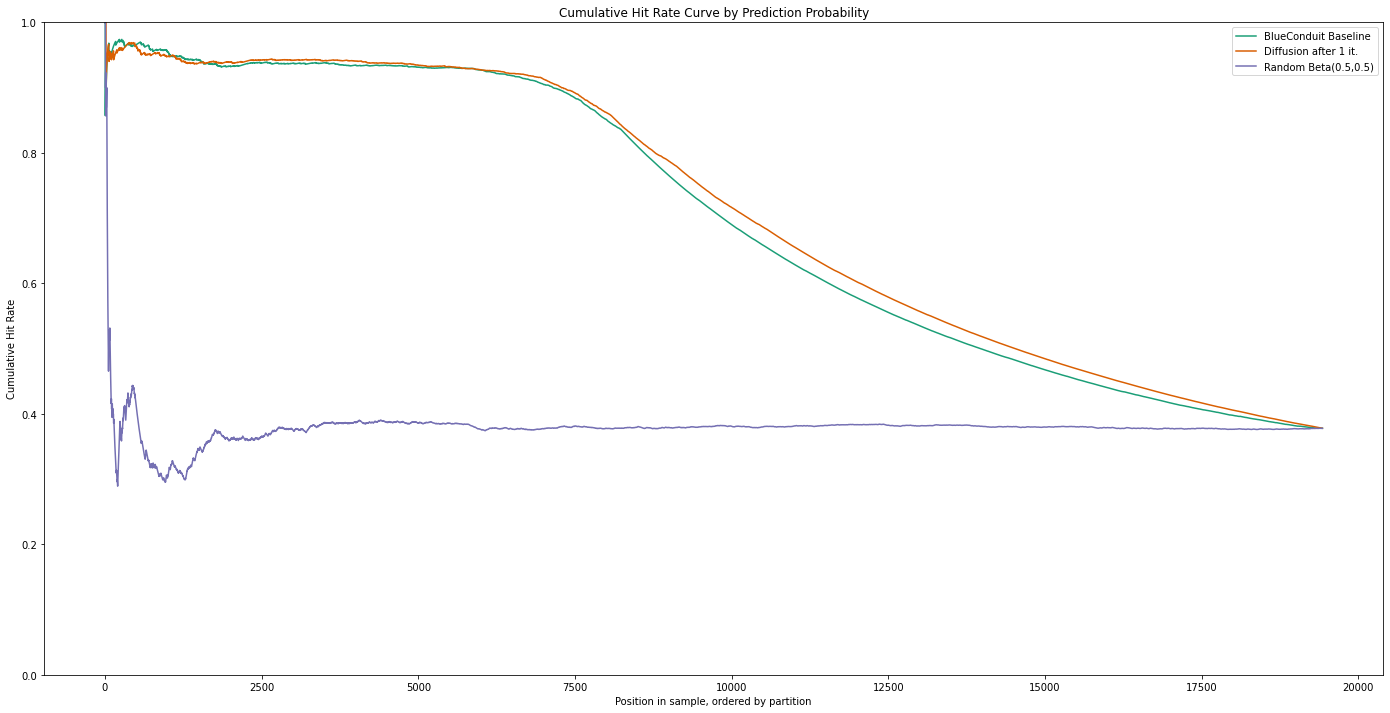

Working on split 2...


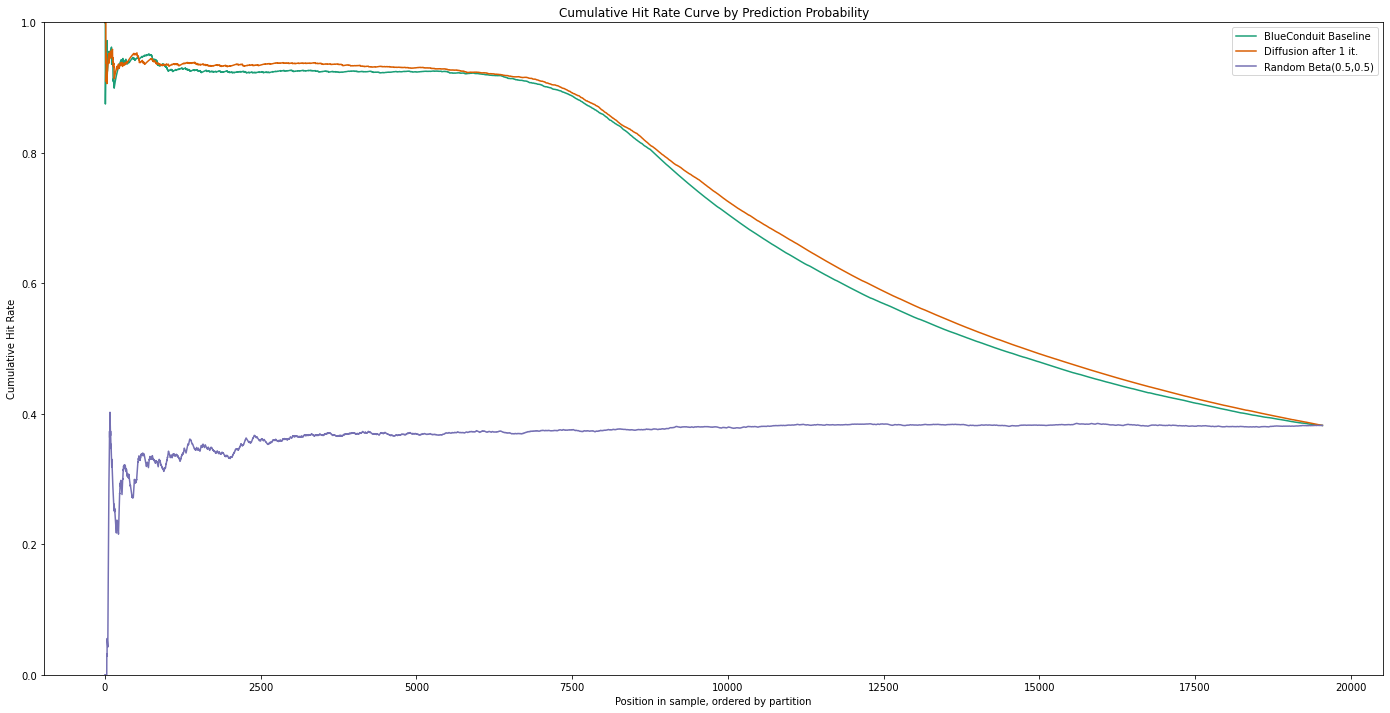

In [ ]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=47)
for split in range(3):
  split_list = []
  split_list_auhrc = []
  print(f"Working on split {split}...")
  (train_index, test_index, 
  Xtrain, Xtest, Ytrain, Ytest, 
  train_pred, test_pred) = tuple(select_data(Xdata, 
                                        Ydata, 
                                        pid, 
                                        train_idx, 
                                        test_idx, 
                                        train_pred_all, 
                                        test_pred_all,
                                        partitions_builder, 
                                        train_size=train_size,
                                        n_hexagons=47,
                                        split=split, 
                                        generate_hexagons=False).values())

  slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred, lam=round(0.6, 2))
  out = slg.fit(n_iter=n_iter, verbose=False, neighbor_fn=ServiceLineDiffusion.graph_Kneighbors, neighbor_params={'graph':graph, 'K': 50})
  split_list.append(log_loss(Ytest, out[test_index]))
  #hrc, _ = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, test_index, Ytest, slg.curr_test_pred, 0.9)
  #auhrc = np.trapz(hrc[250:])
  #split_list_auhrc.append(auhrc)
  plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred, np.random.beta(0.5, 0.5, size=len(test_pred))], 
                      plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {1} it.', 'Random Beta(0.5,0.5)'], 
                      mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9, min_digs=1, threshold_increment=0.1, 
                      figsize=(24,12), savefig=False, figname=f'{n_iter}iter_{train_size}_{99}_{split}.png', figdir=f'{plot_dir}/diffusion/')

## Milestone 2: Figures

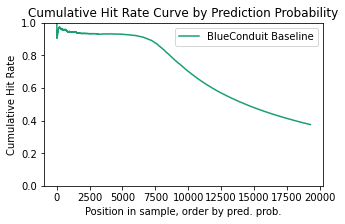

In [ ]:
(train_index, test_index, 
  Xtrain, Xtest, Ytrain, Ytest, 
  train_pred, test_pred) = select_data(Xdata, 
                                        Ydata, 
                                        pid, 
                                        train_idx, 
                                        test_idx, 
                                        train_pred_all, 
                                        test_pred_all,
                                        partitions_builder, 
                                        train_size=train_size,
                                        n_hexagons=hex_size,
                                        split=0, 
                                        generate_hexagons=False)
plot_hit_rate_curve(Ytest, test_pred, plot_probs=False, labels=['BlueConduit Baseline'], mode='all', figsize=(5, 3))

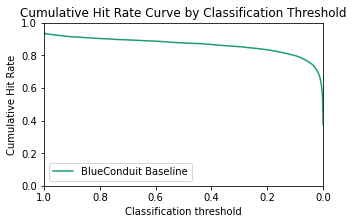

In [ ]:
plot_hit_rate_curve(Ytest, test_pred, plot_probs=False, labels=['BlueConduit Baseline'], mode='all', order_by_prob=True, figsize=(5, 3))

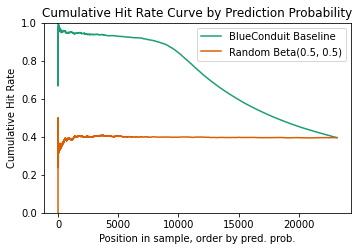

In [ ]:
plot_hit_rate_curve(Ytest, [test_pred, np.random.beta(0.5, 0.5, size=len(test_pred))], plot_probs=False, 
                    labels=['BlueConduit Baseline', 'Random Beta(0.5, 0.5)'], mode='all', figsize=(5.5,3.5))

In [ ]:
from blue_conduit_spatial.utilities import *


## Plotting

In [ ]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=47)

NameError: ignored

In [ ]:
def plot_avg_prediction(hexagons, pid, slg, figsize=(16,6), col='output_pred'):
  part_gdf = hexagons.partition_gdf.copy()
  train_df_w_part_id = pid.iloc[train_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
  train_df_w_part_id['output_pred'] = slg.curr_train_pred

  test_df_w_part_id = pid.iloc[test_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
                            
  test_df_w_part_id['output_pred'] = slg.curr_test_pred
  df_w_part_id = train_df_w_part_id.append(test_df_w_part_id)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  part_gdf.merge(right=df_w_part_id.groupby('partition_ID').mean()[col], on='partition_ID').plot(column=col, figsize=(16,6), legend=True, ax=ax)
  ax.set_axis_off()
  plt.show()





In [ ]:
slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
out = slg.fit(n_iter=0, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
out = slg.fit(n_iter=100, verbose=False)
plot_avg_prediction(hexagons, pid, slg)


In [ ]:
def plot_varof_prediction(hexagons, pid, slg, figsize=(16,6), col='output_pred'):
  part_gdf = hexagons.partition_gdf.copy()
  train_df_w_part_id = pid.iloc[train_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
  train_df_w_part_id['output_pred'] = slg.curr_train_pred

  test_df_w_part_id = pid.iloc[test_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
                            
  test_df_w_part_id['output_pred'] = slg.curr_test_pred
  df_w_part_id = train_df_w_part_id.append(test_df_w_part_id)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  part_gdf.merge(right=df_w_part_id.groupby('partition_ID').std()[col], on='partition_ID').plot(column=col, figsize=(16,6), legend=True, ax=ax)
  ax.set_axis_off()
  plt.show()

In [ ]:
slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
out = slg.fit(n_iter=0, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
plot_varof_prediction(hexagons, pid, slg)
plot_avg_prediction(hexagons, pid, slg, col='has_lead')
plot_varof_prediction(hexagons, pid, slg, col='has_lead')
out = slg.fit(n_iter=100, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
plot_varof_prediction(hexagons, pid, slg)

In [ ]:
train_idx.keys()

for ts in train_idx.keys():
  print(f"train size: {ts}")
  for res in list(train_idx['ts_0.1'].keys()):
    print(res)
    for i in range(3):
      tr_size = train_idx[ts][res][i].shape[0]
      te_size = test_idx[ts][res][i].shape[0]
      print(tr_size + te_size)

## Plot maps in order of digs

In [ ]:
test = hexagons.parcel_gdf.iloc[test_index]

In [ ]:
test['baseline_pred'] = test_pred
test['diffusion_pred'] = slg.curr_test_pred 

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0      397
1      525
2      266
3      352
4      114
      ... 
599    465
600    383
601    482
602    436
603    449
Name: baseline_order, Length: 604, dtype: int64
0      292
1      375
2      539
3      383
4      488
      ... 
599    585
600    406
601    574
602    463
603    505
Name: baseline_order, Length: 604, dtype: int64
0      409
1      565
2       78
3      265
4      399
      ... 
599    198
600    494
601    302
602    472
603    560
Name: baseline_order, Length: 604, dtype: int64
0      221
1      511
2      542
3      255
4      363
      ... 
599     45
600    319
601    280
602    540
603    223
Name: baseline_order, Length: 604, dtype: int64
0      128
1      458
2      227
3      158
4       99
      ... 
599    529
600    515
601    185
602    586
603    254
Name: baseline_order, Length: 604, dtype: int64


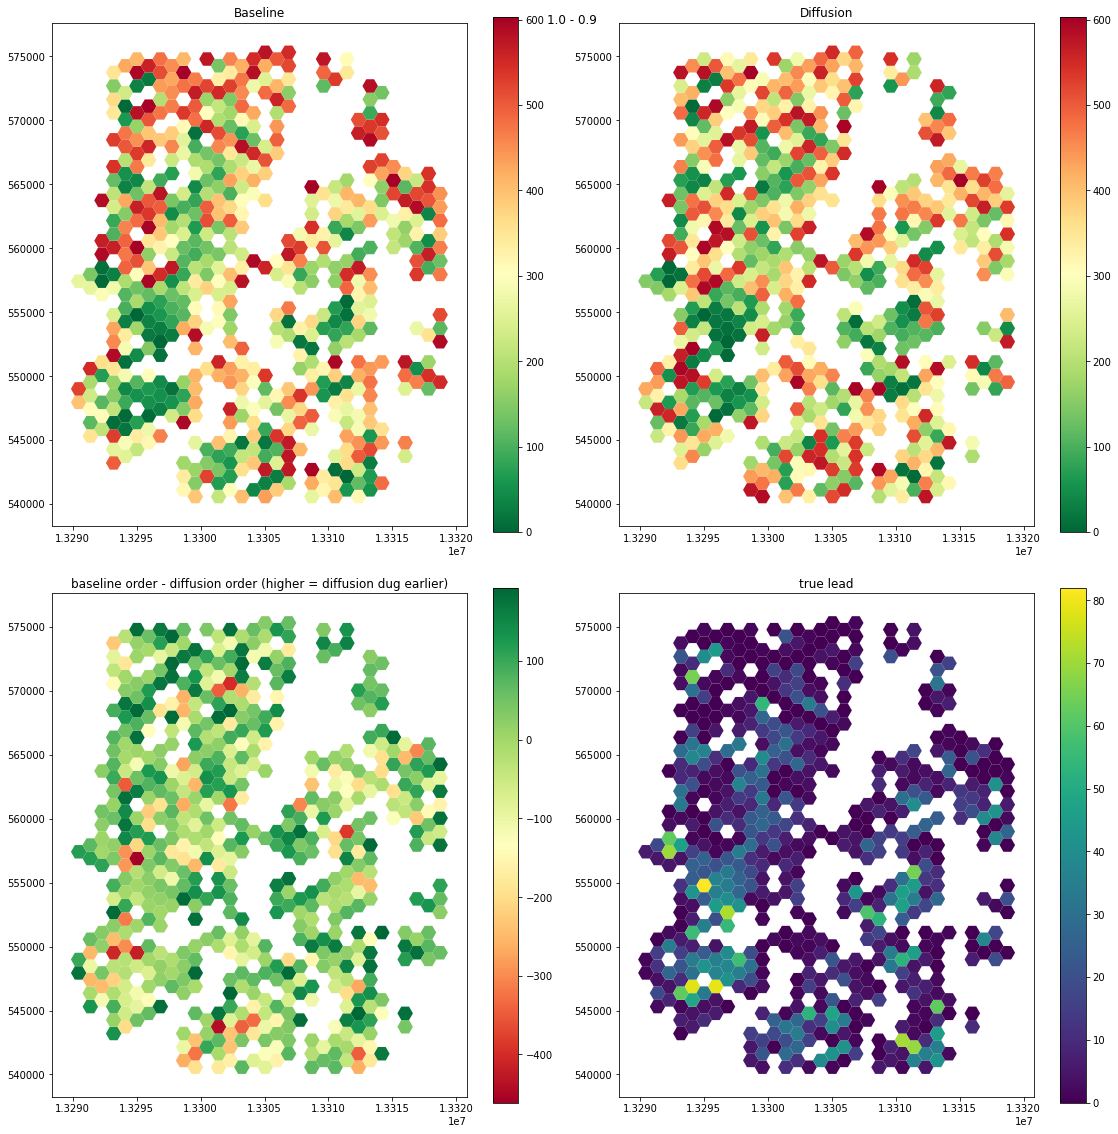

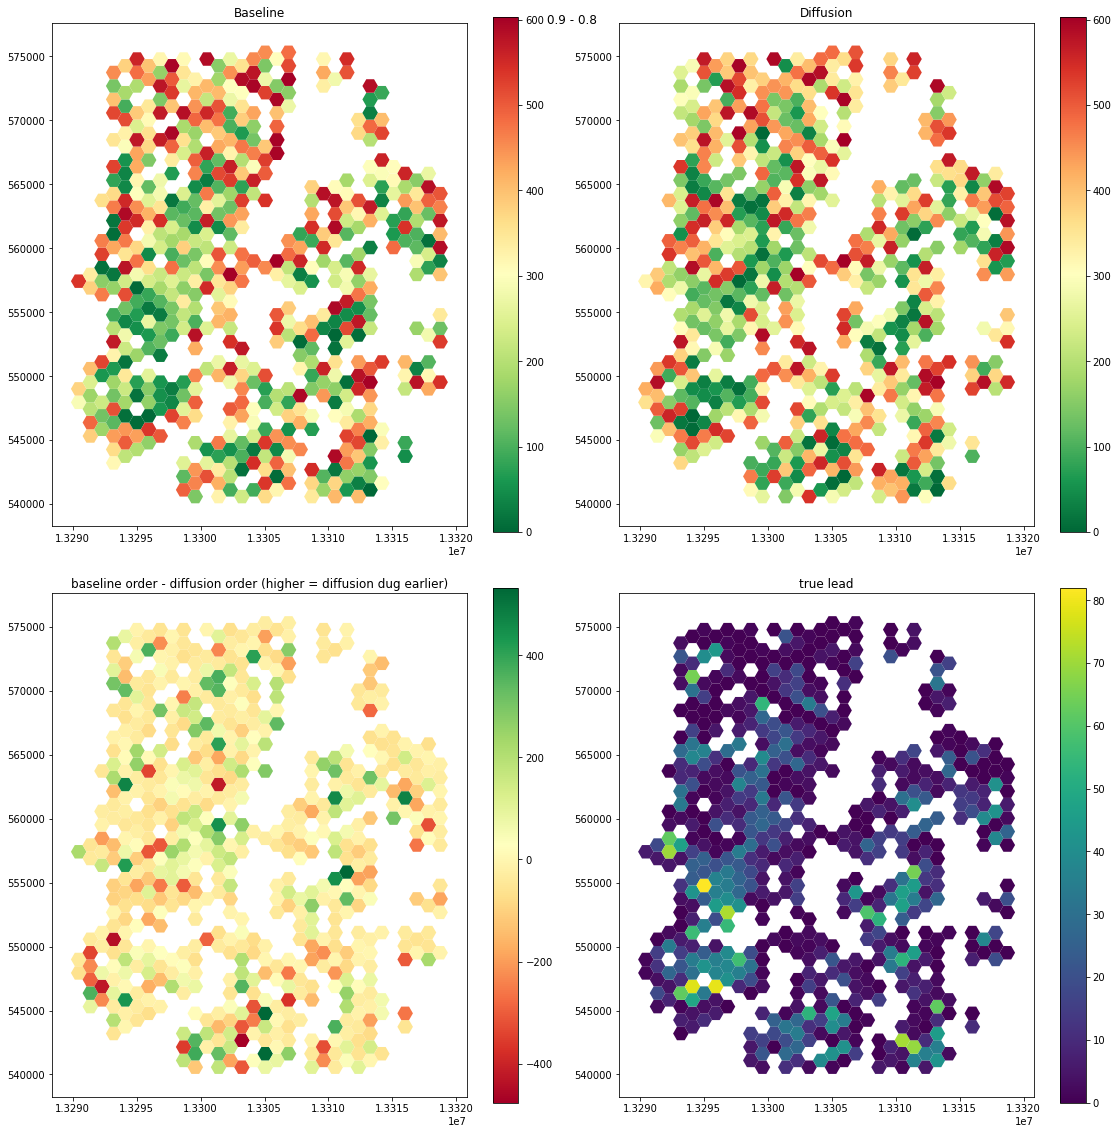

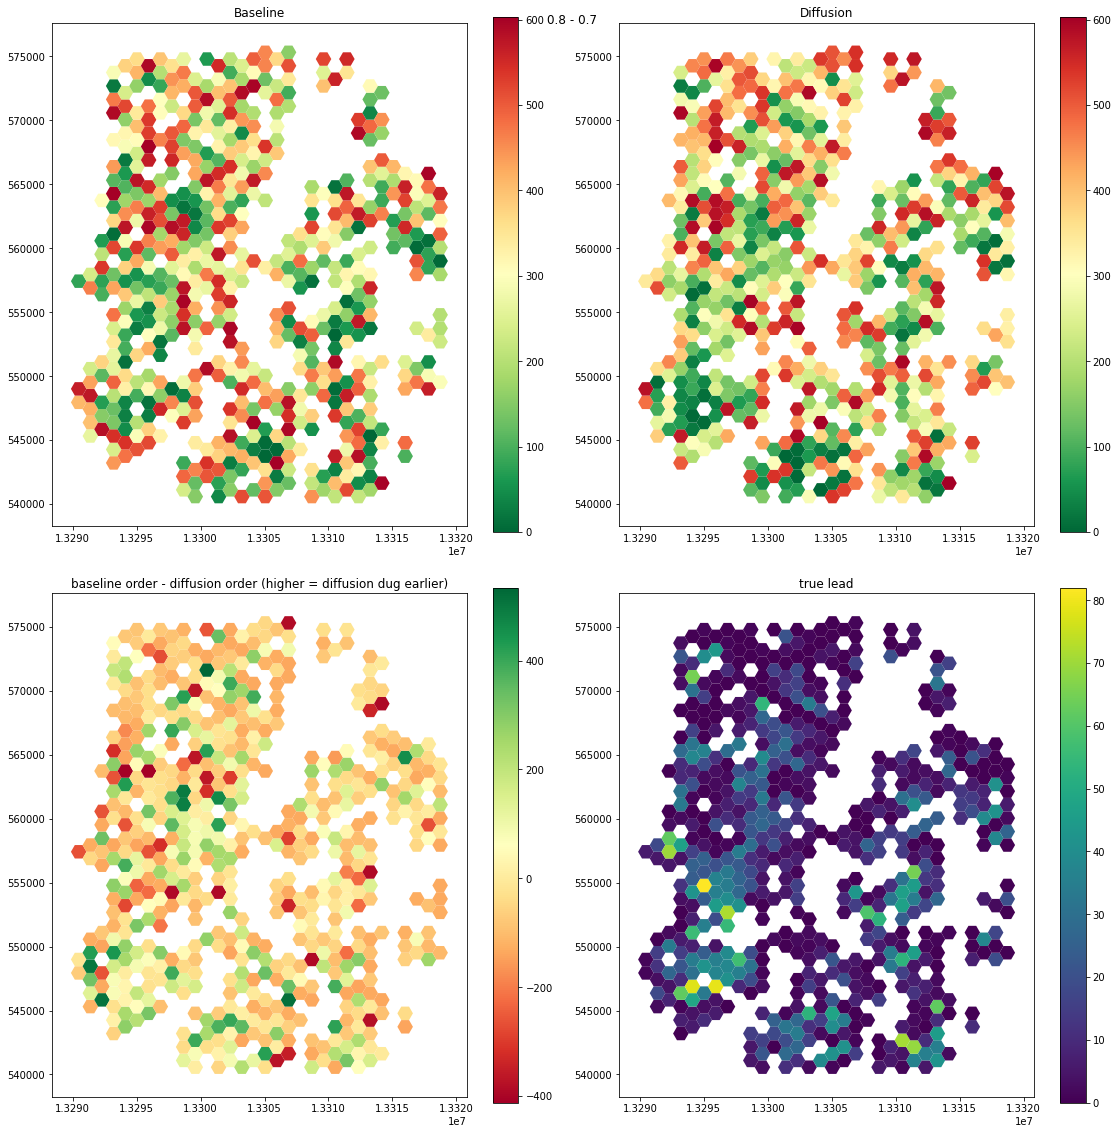

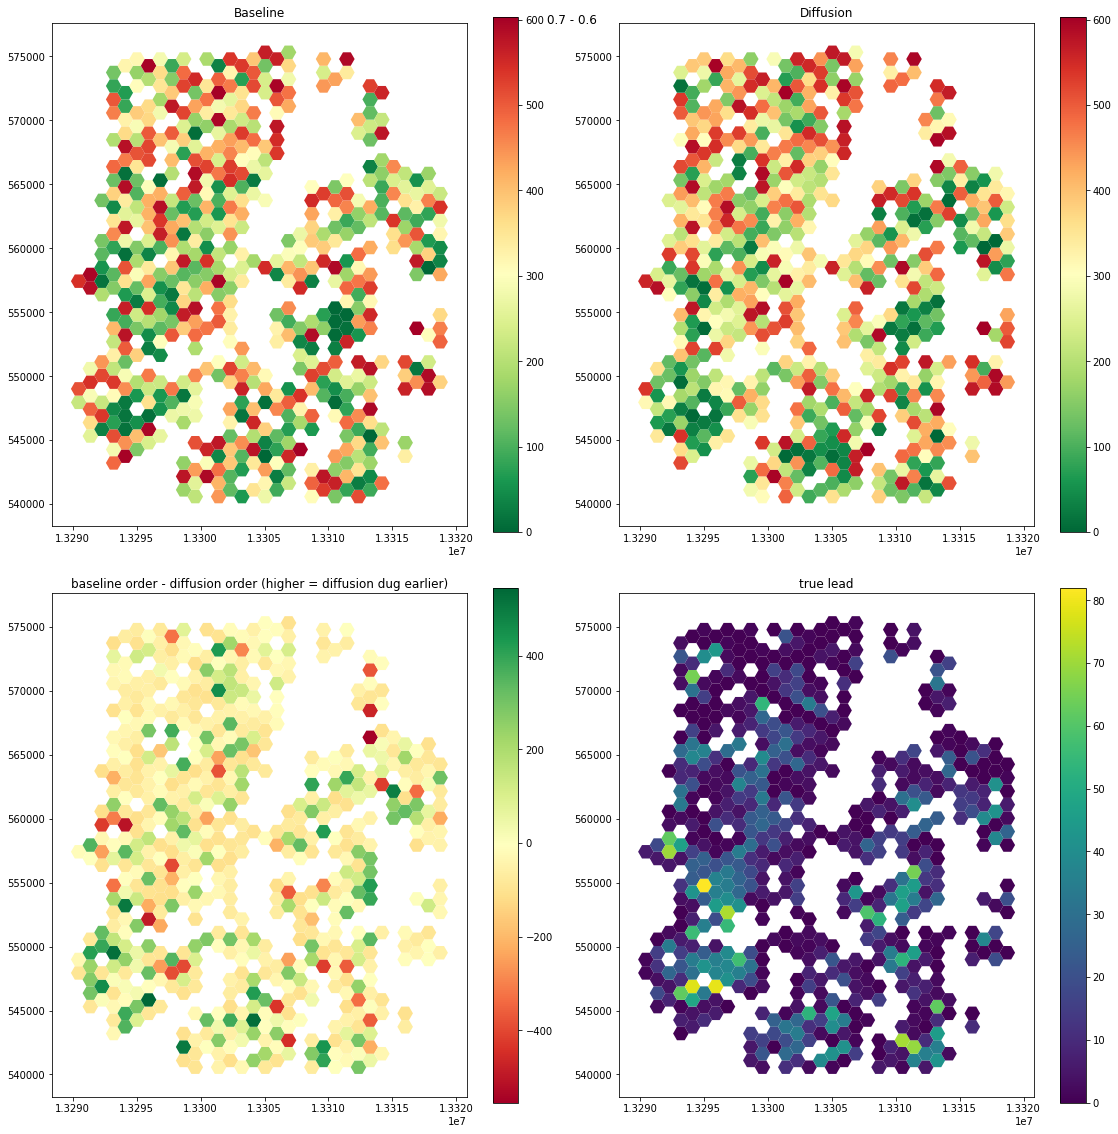

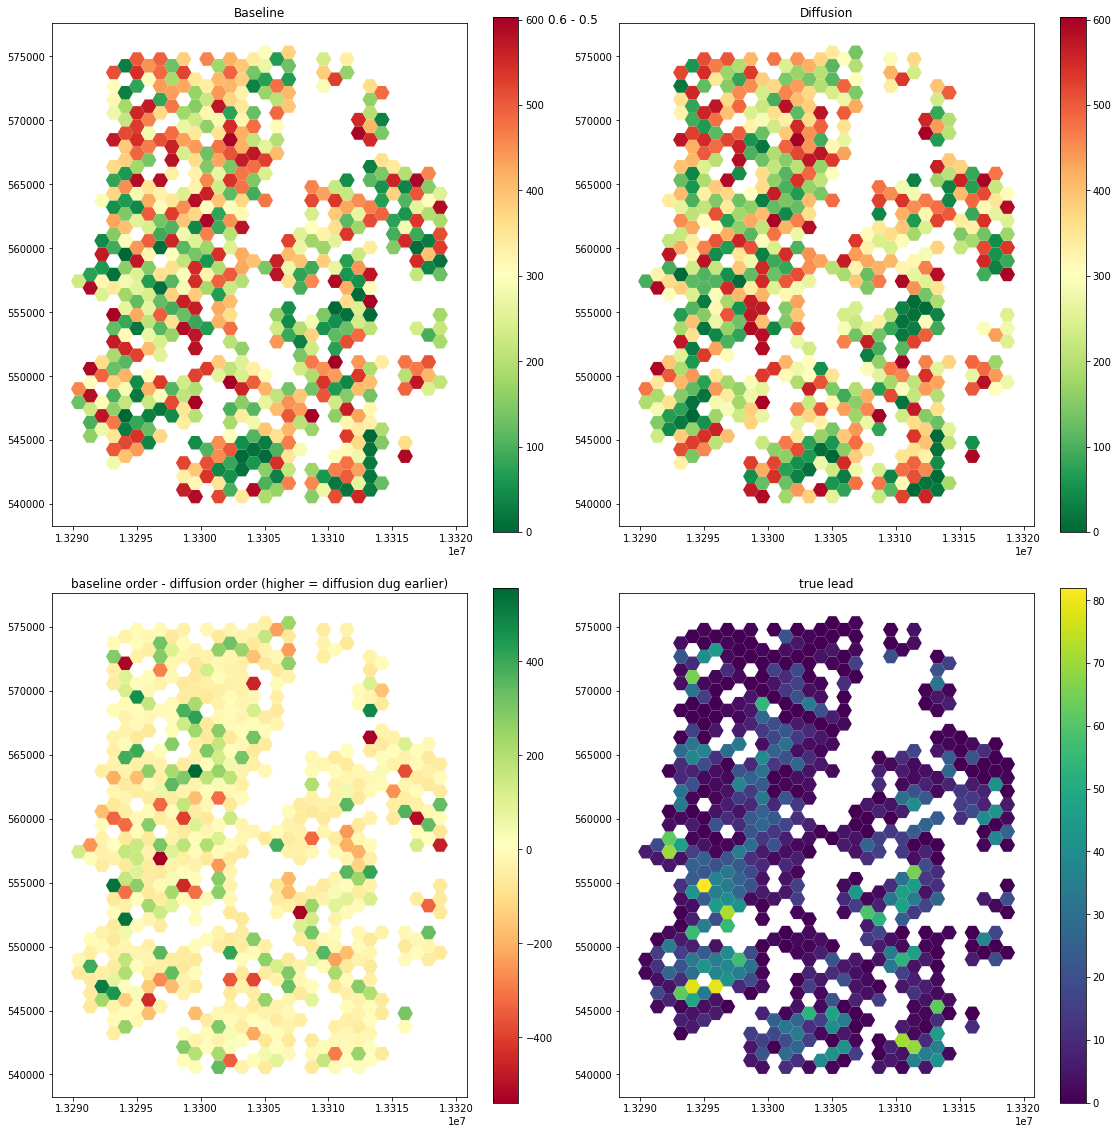

In [ ]:


for i in range(5):
  up_threshold = round(1 - 0.1*i, 2)
  low_threshold = round(up_threshold - 0.1, 2)
  test['baseline_dig'] = (test['baseline_pred'].between(low_threshold, up_threshold)).astype(int)
  test['diffusion_dig'] = (test['diffusion_pred'].between(low_threshold, up_threshold)).astype(int)
  test['dangerous'] = Ytest
  part_gdf = hexagons.partition_gdf
  outcome_df = part_gdf.merge(right=test.groupby('partition_ID').sum()[['baseline_dig', 'diffusion_dig', 'dangerous']], left_on='partition_ID', right_on='partition_ID')
  outcome_df['rand'] = np.random.uniform(size=outcome_df.shape[0])
  outcome_df = outcome_df.merge(right=outcome_df.sort_values(['baseline_dig', 'rand'], ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'baseline_order'}, axis=1), 
                  left_on='partition_ID', right_on='partition_ID')
  outcome_df = outcome_df.merge(right=outcome_df.sort_values(['diffusion_dig', 'rand'], ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'diffusion_order'}, axis=1), 
                  left_on='partition_ID', right_on='partition_ID')
  outcome_df['diffusion_n_earlier'] = outcome_df['baseline_order'] - outcome_df['diffusion_order']
  outcome_df['baseline_diff'] = outcome_df['dangerous'] - outcome_df['baseline_dig']
  outcome_df['diffusion_diff'] = outcome_df['dangerous'] - outcome_df['diffusion_dig']

  fig, axs = plt.subplots(2, 2, figsize=(16,16))
  axs = axs.flatten()

  outcome_df.plot(column='baseline_order', legend=True, ax=axs[0], cmap='RdYlGn_r')
  axs[0].set_title('Baseline')
  outcome_df.plot(column='diffusion_order', legend=True, ax=axs[1], cmap='RdYlGn_r')
  axs[1].set_title('Diffusion')
  outcome_df.plot(column='diffusion_n_earlier', legend=True, ax=axs[2], cmap='RdYlGn')
  axs[2].set_title('baseline order - diffusion order (higher = diffusion dug earlier)')
  outcome_df.plot(column='dangerous', legend=True, ax=axs[3], cmap='viridis')
  axs[3].set_title('true lead')
  #outcome_df.plot(column='baseline_diff', legend=True, ax=axs[4],  cmap='RdYlGn_r', vmin=-20, vmax=20)
  #axs[4].set_title('total lead - baseline digs (higher = baseline too low)')
  #outcome_df.plot(column='diffusion_diff', legend=True, ax=axs[5], cmap='RdYlGn_r', vmin=-20, vmax=20)
  #axs[5].set_title('total lead - diffusion digs (higher = diffusion too low)')
  plt.tight_layout()
  plt.suptitle(f'{up_threshold} - {low_threshold}')
  plt.savefig(f'{plot_dir}/diffusion/threshold_iteration_{i}.png')

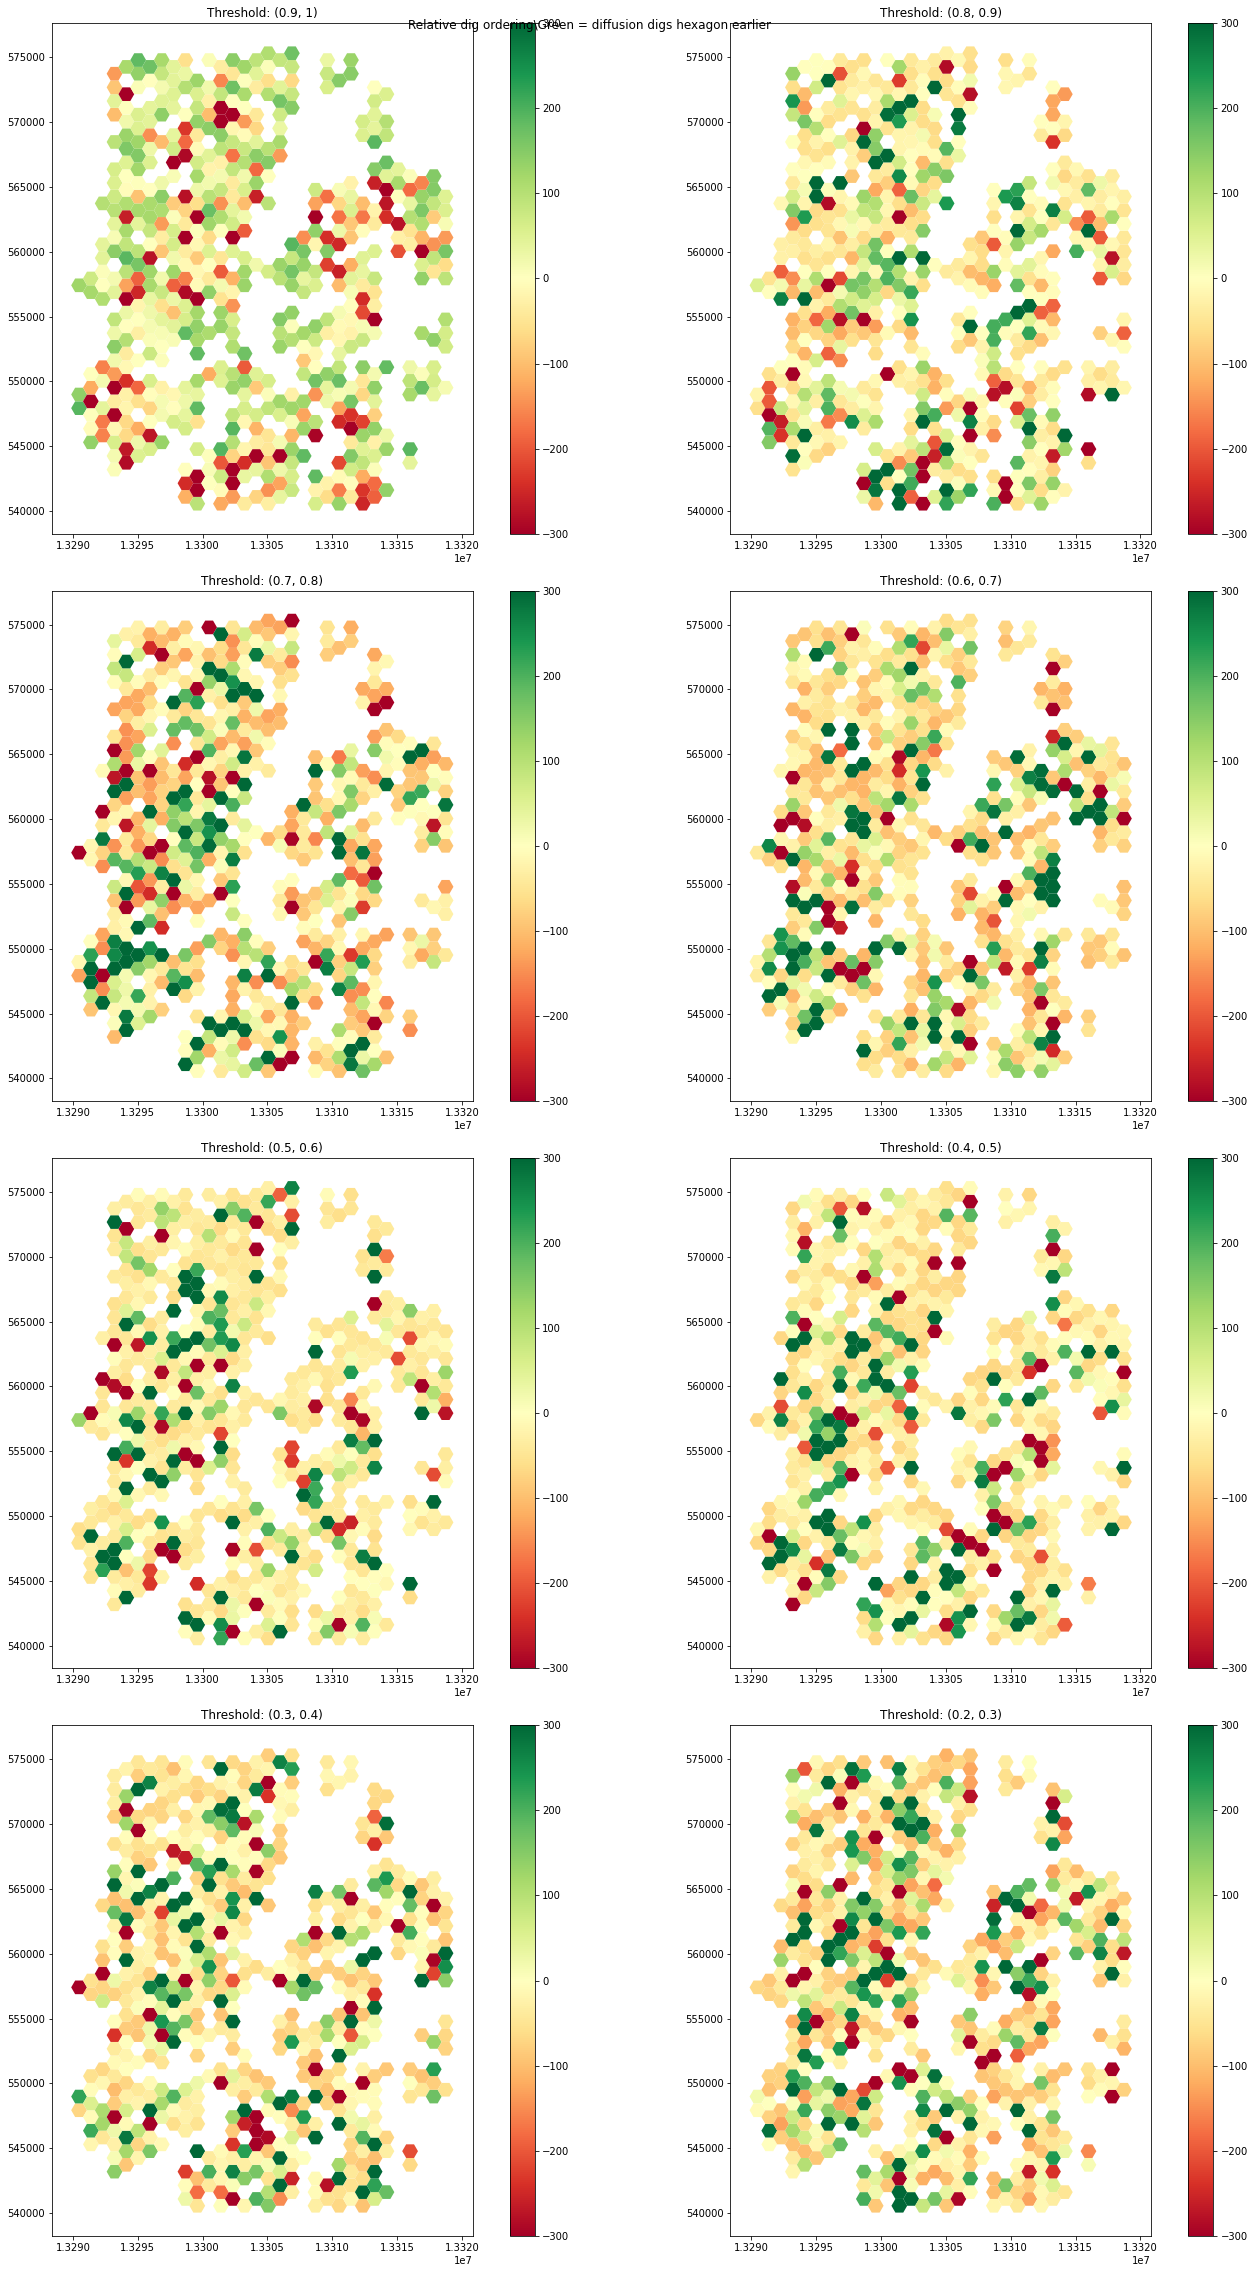

In [ ]:
pd.options.mode.chained_assignment = None
up_threshold = 1
fig, axs = plt.subplots(4, 2, figsize=(20,32))
axs = axs.flatten()
i = 0
while up_threshold > 0.2: 
  low_threshold = round(up_threshold - 0.1, 1)
  test['baseline_dig'] = (test['baseline_pred'].between(low_threshold, up_threshold)).astype(int)
  test['diffusion_dig'] = (test['diffusion_pred'].between(low_threshold, up_threshold)).astype(int)
  test['dangerous'] = Ytest
  part_gdf = hexagons.partition_gdf
    
  outcome_df = part_gdf.merge(right=test.groupby('partition_ID').sum()[['baseline_dig', 'diffusion_dig', 'dangerous']], left_on='partition_ID', right_on='partition_ID')
  outcome_df['rand'] = np.random.uniform(size=outcome_df.shape[0])
  outcome_df = outcome_df.merge(right=outcome_df.sort_values(['baseline_dig', 'rand'], ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'baseline_order'}, axis=1), 
                  left_on='partition_ID', right_on='partition_ID')
  outcome_df = outcome_df.merge(right=outcome_df.sort_values(['diffusion_dig', 'rand'], ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'diffusion_order'}, axis=1), 
                  left_on='partition_ID', right_on='partition_ID')
  outcome_df['diffusion_n_earlier'] = outcome_df['baseline_order'] - outcome_df['diffusion_order']
  outcome_df.plot(column='diffusion_n_earlier', legend=True, cmap='RdYlGn', ax=axs[i], vmin=-300, vmax=300)
  axs[i].set_title(f"Threshold: ({low_threshold}, {up_threshold})")
  up_threshold -= 0.1
  up_threshold = round(up_threshold, 1)
  i += 1

plt.suptitle(f"Relative dig ordering\Green = diffusion digs hexagon earlier")
plt.tight_layout()
plt.savefig(f'{plot_dir}/diffusion/sequential_dig_comparison.png')
plt.show()

  